In [28]:
import os
import csv
import pandas as pd
import plotly.express as px
import sklearn
import matplotlib.pyplot as plt
import numpy as np

EARTHQUAKE_PATH = "datasets/earthquakes.csv"
MAPBOX_ACCESS_KEY = os.environ['MAPBOX_KEY']

# READ EARTHQUAKE CSV FILE
def load_earthquake_data(earthquake_path = EARTHQUAKE_PATH):
    return pd.read_csv(earthquake_path)

# IMPORT DATA AS PANDAS DATAFRAME
df = load_earthquake_data()

In [29]:
### RAW DATA INFO ###
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

### The raw data contains many features, but many of these features cannot be read or have many missing values. Training algorithms do not handle missing data well, so we must either transform features by filling in the missing data points with their median or drop them. Here we decide to drop the columns with many missing data points because either there were too many missing values or the data wasn't significant. 

In [30]:
### DATA CLEANING ###
# Machine learning algorithms do not function appropriately with missing values.

# 1) Dropping columns with many missing feautres.
incomplete_features=['Depth Error', 'Depth Seismic Stations', 'Magnitude Error', 'Magnitude Seismic Stations', 
                    'Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square']
df.drop(incomplete_features, axis=1, inplace=True)

# 2) Dropping rows where magnitude type is missing.
df.dropna(axis=0, how='any', inplace=True)

df.info()

# Data reduction by approx. 33%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23409 entries, 0 to 23411
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              23409 non-null  object 
 1   Time              23409 non-null  object 
 2   Latitude          23409 non-null  float64
 3   Longitude         23409 non-null  float64
 4   Type              23409 non-null  object 
 5   Depth             23409 non-null  float64
 6   Magnitude         23409 non-null  float64
 7   Magnitude Type    23409 non-null  object 
 8   ID                23409 non-null  object 
 9   Source            23409 non-null  object 
 10  Location Source   23409 non-null  object 
 11  Magnitude Source  23409 non-null  object 
 12  Status            23409 non-null  object 
dtypes: float64(4), object(9)
memory usage: 2.5+ MB


### Some features are non-numerical so we convert them to a numerical type.

In [31]:
from sklearn.preprocessing import OrdinalEncoder
### DATA TYPE CONVERSION ###

# Date Conversions
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y', errors = 'raise') 
df['Time'] = pd.to_datetime(df['Time'], format = '%H:%M:%S', errors = 'raise')
# Appending Year, Month, and Date column
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day
df['Day of Year'] = pd.DatetimeIndex(df['Date']).dayofyear

#Appending Hour, Minute, and Second column
df['Hour'] = pd.DatetimeIndex(df['Time']).hour
df['Minute'] = pd.DatetimeIndex(df['Time']).minute
df['Second'] = pd.DatetimeIndex(df['Time']).second

# Enumerating Categorical Types
ordinal_encoder = OrdinalEncoder()
df['Type'] = ordinal_encoder.fit_transform(df[['Type']])
df['Magnitude Type'] = ordinal_encoder.fit_transform(df[['Magnitude Type']])
df['Location Source'] = ordinal_encoder.fit_transform(df[['Location Source']])
df['Source'] = ordinal_encoder.fit_transform(df[['Source']])
df['Magnitude Source'] = ordinal_encoder.fit_transform(df[['Magnitude Source']])
df['Status'] = ordinal_encoder.fit_transform(df[['Status']])

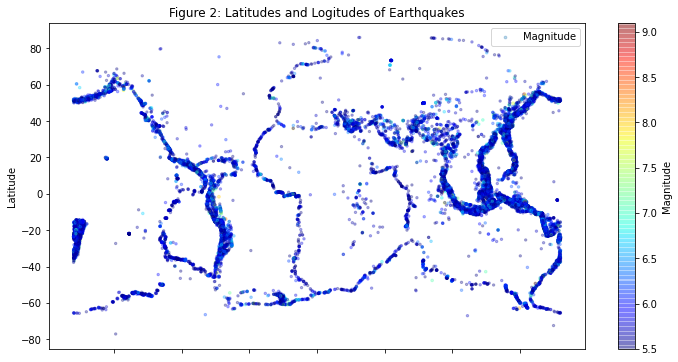

In [32]:
# Visualizing Geographical Data
df.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.3, figsize=(12,6), title="Figure 2: Latitudes and Logitudes of Earthquakes",
       s=df['Magnitude'], label='Magnitude', c='Magnitude', cmap=plt.get_cmap('jet'), colorbar=True,)
plt.legend()

# Display raw data on world map
px.set_mapbox_access_token(MAPBOX_ACCESS_KEY)
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Magnitude", size="Magnitude",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=5, zoom=0, title="Figure 1: Significant Earthquakes from 1965 to 2016")
fig.show()

### Let's begin to analyize our dataset. 
#### We hypothesized that depth and magnitude were strongly positvely correlated.

<AxesSubplot:xlabel='Depth', ylabel='Magnitude'>

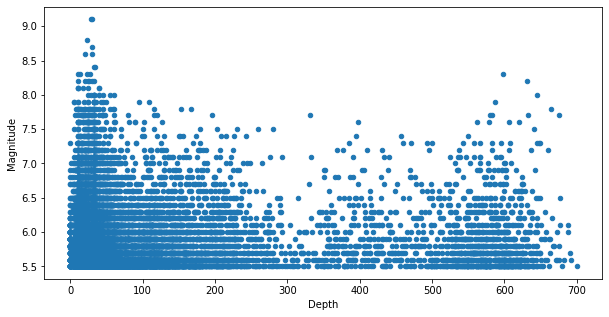

In [33]:
# Looking for Correlations
df.plot.scatter('Depth','Magnitude', figsize=(10,5))

### Let's apply a linear-classifier

Coefficients: 
 [[0.04967809]]
Mean squared error: 873.03
Coefficient of determination: 0.04


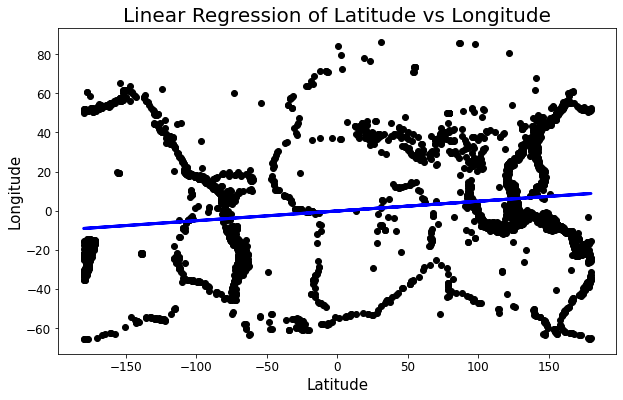

In [34]:
### Scikit-Learn Linear Models ###
### Proving our data set is non-linear using linear regression ###
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

x_lables = ['Longitude']
y_labels = ['Latitude']
X_train, X_test, y_train, y_test = train_test_split(df[x_lables], df[y_labels], test_size=0.2, random_state=42)

# Create linear regression object
lin_reg = linear_model.LinearRegression()

# Train the model using the training sets
lin_reg.fit(X_train, y_train)

# Make predictions using the testing set
lin_reg_pred = lin_reg.predict(X_test)

print('Coefficients: \n', lin_reg.coef_) # COE
print('Mean squared error: %.2f' % mean_squared_error(y_test, lin_reg_pred)) # MSE
print('Coefficient of determination: %.2f' % r2_score(y_test, lin_reg_pred)) # COD

# Plot outputs
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, lin_reg_pred, color='blue', linewidth=3)
plt.title('Linear Regression of Latitude vs Longitude', fontsize = 20)
plt.xlabel('Latitude', fontsize=15)
plt.ylabel('Longitude', fontsize=15)
plt.tick_params(axis='both', labelsize=12)


#Simple linear regression shows just how non-linear our data is. A coefficient of determination of 0.004 tells
#    us that our data is strongly non-linear. Perfect linearlity would occur at 1.0 COE. Therefore, we must 
#    apply non-linear regression algorithms in order to properly model this data.

### Feature Scaling

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Select data for scaling
earthquake_data = df[['Latitude', 'Longitude', 'Depth', 'Day of Year', 'Type']]
labels = df['Magnitude'] # We don't scale the output label.
attribs = list(earthquake_data)

# Standardize the earthquake data // PCA
ct = ColumnTransformer([("num", StandardScaler(), attribs)])
earthquake_prepared = ct.fit_transform(earthquake_data)

X_train, X_test, y_train, y_test = train_test_split(earthquake_prepared, labels, test_size=0.2, random_state=42)

#    _________________________________________________________
#                    |       DATA:              LABELS:       
#    _________________________________________________________
#    TRAINING SET:   |   X_train(18727, 5)  y_train(18727, 1) 
#    VALIDATION SET: |    X_test(4682, 5)    y_test(4682, 1)
#    _________________________________________________________

#### Prepare to test models using cross validation

In [36]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

### Supervised Learning: Random Forest Regressor

In [109]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500, n_jobs=-1)
forest_reg.fit(X_train, y_train)

scores = cross_val_score(forest_reg, earthquake_prepared, labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [0.47113646 0.42670635 0.41869313 0.41630451 0.40867123 0.43211576
 0.42459932 0.42761469 0.42188727 0.4560193 ]
Mean: 0.4303748009724986
Standard Deviation: 0.018039216854685496


### MLP Regressor

In [110]:
from sklearn.neural_network import MLPRegressor

mlp_regr = MLPRegressor(random_state=42, max_iter=5000)
mlp_regr.fit(earthquake_prepared, labels)

scores = cross_val_score(mlp_regr, earthquake_prepared, labels, scoring="neg_mean_squared_error", cv=10)
regr_scores = np.sqrt(-scores)

display_scores(regr_scores)

Scores: [0.47191183 0.41137077 0.41468414 0.41009391 0.41058189 0.43395532
 0.42342223 0.41651116 0.42143475 0.44638114]
Mean: 0.42603471476688515
Standard Deviation: 0.01880657146483633


### Finally, lets train a neural network to predict the expceted magnitue of an earthquake.
#### Inputs
- Latitude, Latitude^2, sin(Latitude)
- Longitude, Longitude^2, sin(Latitude)
- Depth, Depth Squared
- Day of Year
- Type

#### Hidden Layers
- Layer 1: 50 Neurons
- Layer 2: 50 Neurons

#### Output
- Magnitude

In [83]:
import math
earthquake_data = df[['Latitude', 'Longitude', 'Depth', 'Day of Year', 'Type']]
earthquake_data.loc[:, 'Lat^2'] = earthquake_data.loc[:, 'Latitude'].map(lambda lat: lat ** 2)
earthquake_data.loc[:, 'Lon^2'] = earthquake_data.loc[:, 'Longitude'].map(lambda lon: lon ** 2)
earthquake_data.loc[:, 'sin(Lat)'] = earthquake_data.loc[:, 'Latitude'].map(lambda lat: math.sin(lat))
earthquake_data.loc[:, 'sin(Lon)'] = earthquake_data.loc[:, 'Longitude'].map(lambda lon: math.sin(lon))
earthquake_data.loc[:, 'Depth^2' ] = earthquake_data.loc[:, 'Depth'].map(lambda dpth: dpth ** 2)


In [84]:
earthquake_data.head()

,Latitude,Longitude,Depth,Day of Year,Type,Lat^2,Lon^2,sin(Lat),sin(Lon),Depth^2
0,19.246,145.616,131.6,2,0.0,370.408516,21204.019456,0.386141,0.892446,17318.56
1,1.863,127.352,80.0,4,0.0,3.470769,16218.531904,0.957611,0.993105,6400.00
2,-20.579,-173.972,20.0,5,0.0,423.495241,30266.256784,-0.987442,0.926275,400.00
3,-59.076,-23.557,15.0,8,0.0,3489.973776,554.932249,-0.576354,0.999988,225.00
4,11.938,126.427,15.0,9,0.0,142.515844,15983.786329,-0.587827,0.691305,225.00


<AxesSubplot:title={'center':'Longitude vs Latitude'}, xlabel='Longitude', ylabel='Latitude'>

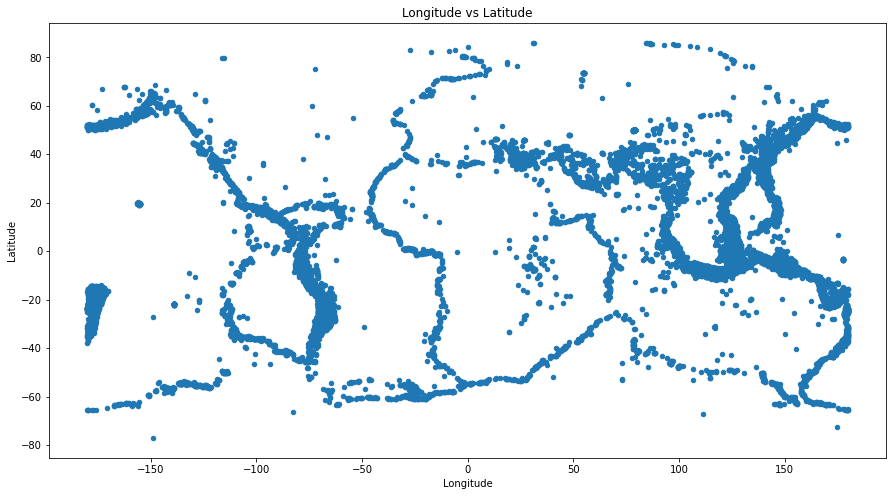

In [85]:
earthquake_data.plot.scatter(x='Longitude', y='Latitude', figsize=(15, 8), title='Longitude vs Latitude')

<AxesSubplot:title={'center':'Longitude^2 vs Latitude^2'}, xlabel='Lon^2', ylabel='Lat^2'>

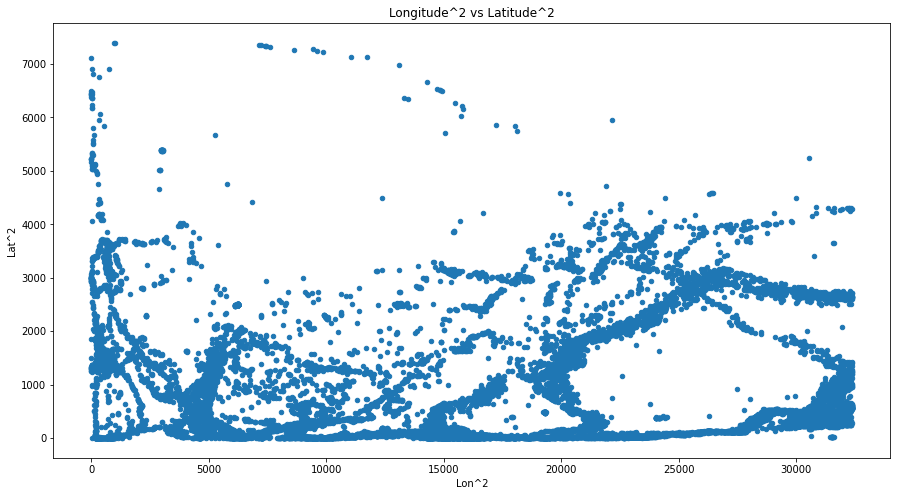

In [86]:
earthquake_data.plot.scatter(x='Lon^2', y='Lat^2', figsize=(15, 8), title='Longitude^2 vs Latitude^2')

<AxesSubplot:title={'center':'sin(Lat) vs sin(Lon)'}, xlabel='sin(Lon)', ylabel='sin(Lat)'>

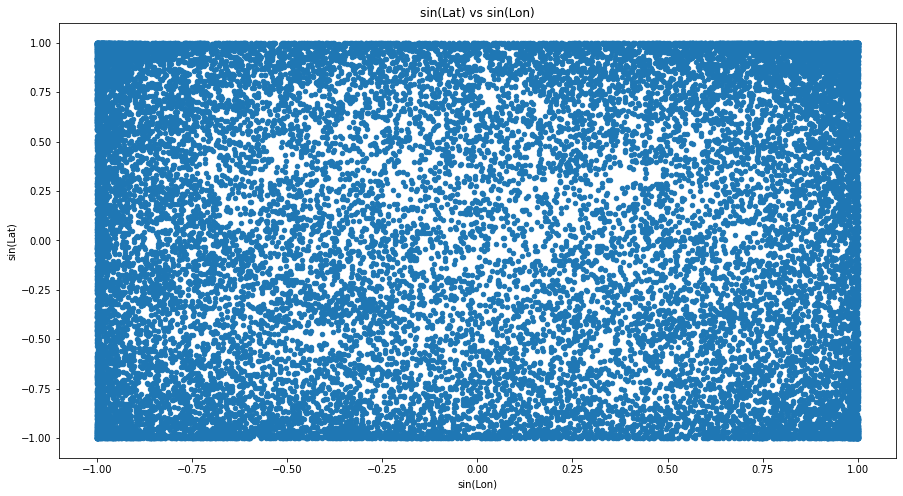

In [87]:
earthquake_data.plot.scatter(x='sin(Lon)', y='sin(Lat)', figsize=(15, 8), title='sin(Lat) vs sin(Lon)')

In [88]:
# Standardize the earthquake data // PCA
attribs = list(earthquake_data)
ct = ColumnTransformer([("num", StandardScaler(), attribs)])
earthquake_prepared = ct.fit_transform(earthquake_data)

X_train, X_test, y_train, y_test = train_test_split(earthquake_prepared, labels, test_size=0.2, random_state=42)

Epoch 1/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.6670 - mae: 0.4664 - val_loss: 0.2020 - val_mae: 0.3221
Epoch 2/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1893 - mae: 0.3232 - val_loss: 0.1949 - val_mae: 0.3410
Epoch 3/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1835 - mae: 0.3182 - val_loss: 0.1885 - val_mae: 0.3227
Epoch 4/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1813 - mae: 0.3160 - val_loss: 0.1871 - val_mae: 0.3121
Epoch 5/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1805 - mae: 0.3149 - val_loss: 0.1962 - val_mae: 0.3549
Epoch 6/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1793 - mae: 0.3143 - val_loss: 0.1858 - val_mae: 0.3178
Epoch 7/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1791 - mae: 0.3147 - val_loss: 0.1847 - val_mae: 0.3125
Epoch 8/1000
586/586 [==============================] - 1s 2ms

Epoch 62/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1749 - mae: 0.3101 - val_loss: 0.1936 - val_mae: 0.3501
Epoch 63/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1747 - mae: 0.3102 - val_loss: 0.1909 - val_mae: 0.3441
Epoch 64/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1748 - mae: 0.3103 - val_loss: 0.1843 - val_mae: 0.3072
Epoch 65/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1746 - mae: 0.3099 - val_loss: 0.1841 - val_mae: 0.3251
Epoch 66/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1746 - mae: 0.3100 - val_loss: 0.1928 - val_mae: 0.2982
Epoch 67/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1746 - mae: 0.3102 - val_loss: 0.1840 - val_mae: 0.3075
Epoch 68/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1745 - mae: 0.3099 - val_loss: 0.1837 - val_mae: 0.3159
Epoch 69/1000
586/586 [==============================] 

586/586 [==============================] - 1s 2ms/step - loss: 0.1736 - mae: 0.3093 - val_loss: 0.1851 - val_mae: 0.3266
Epoch 123/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1733 - mae: 0.3087 - val_loss: 0.1838 - val_mae: 0.3073
Epoch 124/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1733 - mae: 0.3085 - val_loss: 0.1829 - val_mae: 0.3109
Epoch 125/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1732 - mae: 0.3085 - val_loss: 0.1909 - val_mae: 0.2991
Epoch 126/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1731 - mae: 0.3086 - val_loss: 0.1979 - val_mae: 0.2975
Epoch 127/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1734 - mae: 0.3086 - val_loss: 0.1871 - val_mae: 0.3012
Epoch 128/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1730 - mae: 0.3084 - val_loss: 0.1857 - val_mae: 0.3047
Epoch 129/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1726 - mae: 0.3076 - val_loss: 0.1830 - val_mae: 0.3170
Epoch 183/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1725 - mae: 0.3079 - val_loss: 0.1910 - val_mae: 0.2999
Epoch 184/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1723 - mae: 0.3074 - val_loss: 0.1848 - val_mae: 0.3247
Epoch 185/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1728 - mae: 0.3083 - val_loss: 0.1924 - val_mae: 0.2993
Epoch 186/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1725 - mae: 0.3080 - val_loss: 0.1940 - val_mae: 0.2981
Epoch 187/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1725 - mae: 0.3078 - val_loss: 0.1924 - val_mae: 0.3466
Epoch 188/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1723 - mae: 0.3076 - val_loss: 0.1845 - val_mae: 0.3061
Epoch 189/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1711 - mae: 0.3067 - val_loss: 0.1836 - val_mae: 0.3150
Epoch 243/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1715 - mae: 0.3068 - val_loss: 0.1942 - val_mae: 0.3514
Epoch 244/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1713 - mae: 0.3069 - val_loss: 0.1842 - val_mae: 0.3227
Epoch 245/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1711 - mae: 0.3066 - val_loss: 0.1850 - val_mae: 0.3080
Epoch 246/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1714 - mae: 0.3064 - val_loss: 0.1881 - val_mae: 0.3022
Epoch 247/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1717 - mae: 0.3069 - val_loss: 0.1836 - val_mae: 0.3158
Epoch 248/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1712 - mae: 0.3066 - val_loss: 0.1852 - val_mae: 0.3060
Epoch 249/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1706 - mae: 0.3059 - val_loss: 0.1859 - val_mae: 0.3071
Epoch 303/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1708 - mae: 0.3062 - val_loss: 0.1940 - val_mae: 0.3503
Epoch 304/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1705 - mae: 0.3062 - val_loss: 0.1837 - val_mae: 0.3178
Epoch 305/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1707 - mae: 0.3062 - val_loss: 0.1848 - val_mae: 0.3092
Epoch 306/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1710 - mae: 0.3065 - val_loss: 0.1893 - val_mae: 0.3391
Epoch 307/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1707 - mae: 0.3064 - val_loss: 0.1840 - val_mae: 0.3113
Epoch 308/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1708 - mae: 0.3062 - val_loss: 0.1838 - val_mae: 0.3172
Epoch 309/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1699 - mae: 0.3052 - val_loss: 0.1841 - val_mae: 0.3169
Epoch 363/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1700 - mae: 0.3057 - val_loss: 0.1865 - val_mae: 0.3095
Epoch 364/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1701 - mae: 0.3055 - val_loss: 0.1872 - val_mae: 0.3309
Epoch 365/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1701 - mae: 0.3054 - val_loss: 0.1895 - val_mae: 0.3028
Epoch 366/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1698 - mae: 0.3053 - val_loss: 0.1868 - val_mae: 0.3070
Epoch 367/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1701 - mae: 0.3055 - val_loss: 0.1963 - val_mae: 0.3544
Epoch 368/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1698 - mae: 0.3053 - val_loss: 0.1934 - val_mae: 0.3000
Epoch 369/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1689 - mae: 0.3039 - val_loss: 0.1883 - val_mae: 0.3260
Epoch 423/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1690 - mae: 0.3045 - val_loss: 0.1843 - val_mae: 0.3175
Epoch 424/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1693 - mae: 0.3049 - val_loss: 0.1847 - val_mae: 0.3121
Epoch 425/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1693 - mae: 0.3045 - val_loss: 0.1846 - val_mae: 0.3150
Epoch 426/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1694 - mae: 0.3047 - val_loss: 0.1968 - val_mae: 0.3005
Epoch 427/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1692 - mae: 0.3046 - val_loss: 0.1842 - val_mae: 0.3205
Epoch 428/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1693 - mae: 0.3047 - val_loss: 0.1850 - val_mae: 0.3211
Epoch 429/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1685 - mae: 0.3040 - val_loss: 0.1862 - val_mae: 0.3164
Epoch 483/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1687 - mae: 0.3040 - val_loss: 0.1970 - val_mae: 0.3545
Epoch 484/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1686 - mae: 0.3043 - val_loss: 0.1941 - val_mae: 0.3475
Epoch 485/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1688 - mae: 0.3045 - val_loss: 0.1889 - val_mae: 0.3357
Epoch 486/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1685 - mae: 0.3044 - val_loss: 0.1852 - val_mae: 0.3217
Epoch 487/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1686 - mae: 0.3039 - val_loss: 0.1968 - val_mae: 0.3445
Epoch 488/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1686 - mae: 0.3041 - val_loss: 0.1918 - val_mae: 0.3411
Epoch 489/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1681 - mae: 0.3038 - val_loss: 0.1870 - val_mae: 0.3238
Epoch 543/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1683 - mae: 0.3040 - val_loss: 0.1864 - val_mae: 0.3122
Epoch 544/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1678 - mae: 0.3033 - val_loss: 0.1854 - val_mae: 0.3163
Epoch 545/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1680 - mae: 0.3039 - val_loss: 0.1995 - val_mae: 0.3024
Epoch 546/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1680 - mae: 0.3032 - val_loss: 0.1886 - val_mae: 0.3069
Epoch 547/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1680 - mae: 0.3034 - val_loss: 0.2000 - val_mae: 0.3020
Epoch 548/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1678 - mae: 0.3033 - val_loss: 0.1887 - val_mae: 0.3333
Epoch 549/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1674 - mae: 0.3031 - val_loss: 0.1859 - val_mae: 0.3216
Epoch 603/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1675 - mae: 0.3031 - val_loss: 0.1867 - val_mae: 0.3253
Epoch 604/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1674 - mae: 0.3028 - val_loss: 0.1922 - val_mae: 0.3047
Epoch 605/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1676 - mae: 0.3035 - val_loss: 0.1957 - val_mae: 0.3493
Epoch 606/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1671 - mae: 0.3028 - val_loss: 0.1871 - val_mae: 0.3139
Epoch 607/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1674 - mae: 0.3031 - val_loss: 0.1877 - val_mae: 0.3101
Epoch 608/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1678 - mae: 0.3031 - val_loss: 0.1865 - val_mae: 0.3171
Epoch 609/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1672 - mae: 0.3034 - val_loss: 0.2054 - val_mae: 0.3034
Epoch 663/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1670 - mae: 0.3024 - val_loss: 0.1875 - val_mae: 0.3229
Epoch 664/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1669 - mae: 0.3028 - val_loss: 0.1891 - val_mae: 0.3295
Epoch 665/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1668 - mae: 0.3026 - val_loss: 0.1893 - val_mae: 0.3118
Epoch 666/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1669 - mae: 0.3027 - val_loss: 0.1876 - val_mae: 0.3230
Epoch 667/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1672 - mae: 0.3028 - val_loss: 0.1896 - val_mae: 0.3318
Epoch 668/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1669 - mae: 0.3029 - val_loss: 0.1874 - val_mae: 0.3140
Epoch 669/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1665 - mae: 0.3019 - val_loss: 0.1936 - val_mae: 0.3448
Epoch 723/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1666 - mae: 0.3020 - val_loss: 0.1941 - val_mae: 0.3414
Epoch 724/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1664 - mae: 0.3022 - val_loss: 0.2088 - val_mae: 0.3709
Epoch 725/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1663 - mae: 0.3023 - val_loss: 0.1873 - val_mae: 0.3226
Epoch 726/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1662 - mae: 0.3020 - val_loss: 0.1870 - val_mae: 0.3138
Epoch 727/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1662 - mae: 0.3023 - val_loss: 0.1895 - val_mae: 0.3108
Epoch 728/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1662 - mae: 0.3021 - val_loss: 0.1939 - val_mae: 0.3446
Epoch 729/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1659 - mae: 0.3020 - val_loss: 0.1984 - val_mae: 0.3041
Epoch 783/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1657 - mae: 0.3018 - val_loss: 0.2004 - val_mae: 0.3044
Epoch 784/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1652 - mae: 0.3014 - val_loss: 0.1878 - val_mae: 0.3183
Epoch 785/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1662 - mae: 0.3020 - val_loss: 0.1951 - val_mae: 0.3061
Epoch 786/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1661 - mae: 0.3018 - val_loss: 0.1897 - val_mae: 0.3286
Epoch 787/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1657 - mae: 0.3021 - val_loss: 0.1889 - val_mae: 0.3276
Epoch 788/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1658 - mae: 0.3013 - val_loss: 0.1956 - val_mae: 0.3058
Epoch 789/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1654 - mae: 0.3011 - val_loss: 0.2328 - val_mae: 0.4022
Epoch 843/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1655 - mae: 0.3017 - val_loss: 0.1900 - val_mae: 0.3136
Epoch 844/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1650 - mae: 0.3013 - val_loss: 0.1916 - val_mae: 0.3093
Epoch 845/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1653 - mae: 0.3009 - val_loss: 0.1895 - val_mae: 0.3144
Epoch 846/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1652 - mae: 0.3011 - val_loss: 0.1909 - val_mae: 0.3284
Epoch 847/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1650 - mae: 0.3008 - val_loss: 0.1917 - val_mae: 0.3366
Epoch 848/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1650 - mae: 0.3011 - val_loss: 0.1896 - val_mae: 0.3139
Epoch 849/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1642 - mae: 0.3005 - val_loss: 0.1904 - val_mae: 0.3304
Epoch 903/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1644 - mae: 0.3004 - val_loss: 0.1896 - val_mae: 0.3297
Epoch 904/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1650 - mae: 0.3005 - val_loss: 0.1912 - val_mae: 0.3150
Epoch 905/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1645 - mae: 0.3004 - val_loss: 0.1882 - val_mae: 0.3237
Epoch 906/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1646 - mae: 0.3006 - val_loss: 0.1882 - val_mae: 0.3190
Epoch 907/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1647 - mae: 0.3007 - val_loss: 0.1925 - val_mae: 0.3089
Epoch 908/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1647 - mae: 0.3010 - val_loss: 0.1886 - val_mae: 0.3219
Epoch 909/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1642 - mae: 0.3004 - val_loss: 0.2038 - val_mae: 0.3085
Epoch 963/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1641 - mae: 0.3002 - val_loss: 0.1993 - val_mae: 0.3066
Epoch 964/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1641 - mae: 0.2999 - val_loss: 0.2073 - val_mae: 0.3660
Epoch 965/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1637 - mae: 0.2997 - val_loss: 0.2102 - val_mae: 0.3713
Epoch 966/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1639 - mae: 0.3001 - val_loss: 0.1980 - val_mae: 0.3519
Epoch 967/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1638 - mae: 0.2998 - val_loss: 0.1978 - val_mae: 0.3088
Epoch 968/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1642 - mae: 0.3004 - val_loss: 0.1912 - val_mae: 0.3321
Epoch 969/1000
586/586 [==============================] - 1s 2m

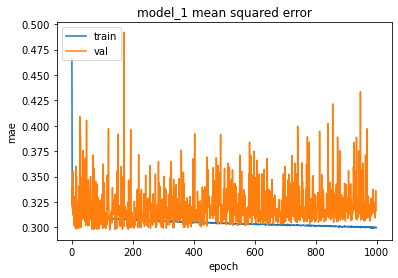

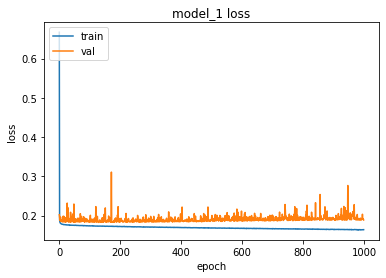

In [89]:
import tensorflow as tf
from tensorflow import keras


model1 = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", name="input"),
    keras.layers.Dense(50, activation="relu", name="h1"),
    keras.layers.Dense(50, activation="relu", name="h2"),
    keras.layers.Dense(1)
])

model1.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae'])
model1_fit = model1.fit(X_train, y_train, epochs=1000,
                   validation_data=(X_test, y_test))

plt.plot(model1_fit.history['mae'])
plt.plot(model1_fit.history['val_mae'])
plt.title('model_1 mean squared error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model1_fit.history['loss'])
plt.plot(model1_fit.history['val_loss'])
plt.title('model_1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.6487 - mae: 0.5377 - val_loss: 0.2819 - val_mae: 0.3951
Epoch 2/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.2343 - mae: 0.3627 - val_loss: 0.2268 - val_mae: 0.3522
Epoch 3/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.2054 - mae: 0.3377 - val_loss: 0.2091 - val_mae: 0.3345
Epoch 4/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1938 - mae: 0.3277 - val_loss: 0.2002 - val_mae: 0.3266
Epoch 5/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1884 - mae: 0.3229 - val_loss: 0.1949 - val_mae: 0.3249
Epoch 6/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1850 - mae: 0.3203 - val_loss: 0.1929 - val_mae: 0.3217
Epoch 7/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1832 - mae: 0.3189 - val_loss: 0.1903 - val_mae: 0.3173
Epoch 8/1000
586/586 [==============================] - 1s 1ms

Epoch 62/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1767 - mae: 0.3120 - val_loss: 0.1845 - val_mae: 0.3115
Epoch 63/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1766 - mae: 0.3123 - val_loss: 0.1872 - val_mae: 0.3050
Epoch 64/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1765 - mae: 0.3125 - val_loss: 0.1844 - val_mae: 0.3130
Epoch 65/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1769 - mae: 0.3123 - val_loss: 0.1839 - val_mae: 0.3150
Epoch 66/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1767 - mae: 0.3122 - val_loss: 0.1868 - val_mae: 0.3321
Epoch 67/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1767 - mae: 0.3123 - val_loss: 0.1866 - val_mae: 0.3276
Epoch 68/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1765 - mae: 0.3120 - val_loss: 0.1872 - val_mae: 0.3065
Epoch 69/1000
586/586 [==============================] 

586/586 [==============================] - 1s 1ms/step - loss: 0.1760 - mae: 0.3116 - val_loss: 0.1828 - val_mae: 0.3118
Epoch 123/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1760 - mae: 0.3115 - val_loss: 0.1837 - val_mae: 0.3106
Epoch 124/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1761 - mae: 0.3118 - val_loss: 0.1832 - val_mae: 0.3082
Epoch 125/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1760 - mae: 0.3116 - val_loss: 0.1895 - val_mae: 0.3357
Epoch 126/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1759 - mae: 0.3113 - val_loss: 0.1853 - val_mae: 0.3052
Epoch 127/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1760 - mae: 0.3115 - val_loss: 0.1876 - val_mae: 0.3039
Epoch 128/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1761 - mae: 0.3117 - val_loss: 0.1847 - val_mae: 0.3158
Epoch 129/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1757 - mae: 0.3109 - val_loss: 0.1829 - val_mae: 0.3172
Epoch 183/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1757 - mae: 0.3111 - val_loss: 0.1877 - val_mae: 0.3252
Epoch 184/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1758 - mae: 0.3113 - val_loss: 0.1870 - val_mae: 0.3303
Epoch 185/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1757 - mae: 0.3111 - val_loss: 0.1840 - val_mae: 0.3061
Epoch 186/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3108 - val_loss: 0.1849 - val_mae: 0.3126
Epoch 187/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1756 - mae: 0.3114 - val_loss: 0.1861 - val_mae: 0.3029
Epoch 188/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1758 - mae: 0.3113 - val_loss: 0.1828 - val_mae: 0.3168
Epoch 189/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1756 - mae: 0.3112 - val_loss: 0.1834 - val_mae: 0.3223
Epoch 243/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3110 - val_loss: 0.1909 - val_mae: 0.3388
Epoch 244/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1755 - mae: 0.3112 - val_loss: 0.1862 - val_mae: 0.3242
Epoch 245/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1756 - mae: 0.3111 - val_loss: 0.1837 - val_mae: 0.3097
Epoch 246/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3108 - val_loss: 0.1834 - val_mae: 0.3156
Epoch 247/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1755 - mae: 0.3112 - val_loss: 0.1840 - val_mae: 0.3117
Epoch 248/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1756 - mae: 0.3107 - val_loss: 0.1836 - val_mae: 0.3203
Epoch 249/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3111 - val_loss: 0.1824 - val_mae: 0.3114
Epoch 303/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3114 - val_loss: 0.1916 - val_mae: 0.2982
Epoch 304/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1755 - mae: 0.3108 - val_loss: 0.1877 - val_mae: 0.3016
Epoch 305/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3104 - val_loss: 0.1834 - val_mae: 0.3204
Epoch 306/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3110 - val_loss: 0.1881 - val_mae: 0.3029
Epoch 307/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3107 - val_loss: 0.1837 - val_mae: 0.3241
Epoch 308/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3109 - val_loss: 0.1871 - val_mae: 0.3340
Epoch 309/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1755 - mae: 0.3109 - val_loss: 0.1840 - val_mae: 0.3249
Epoch 363/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3106 - val_loss: 0.1832 - val_mae: 0.3162
Epoch 364/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3106 - val_loss: 0.1824 - val_mae: 0.3127
Epoch 365/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3108 - val_loss: 0.1848 - val_mae: 0.3093
Epoch 366/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3108 - val_loss: 0.1862 - val_mae: 0.3315
Epoch 367/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3111 - val_loss: 0.1843 - val_mae: 0.3096
Epoch 368/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3108 - val_loss: 0.1832 - val_mae: 0.3082
Epoch 369/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3109 - val_loss: 0.1844 - val_mae: 0.3069
Epoch 423/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3108 - val_loss: 0.1879 - val_mae: 0.3374
Epoch 424/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3107 - val_loss: 0.1844 - val_mae: 0.3087
Epoch 425/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3104 - val_loss: 0.1982 - val_mae: 0.3586
Epoch 426/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1754 - mae: 0.3110 - val_loss: 0.1826 - val_mae: 0.3180
Epoch 427/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3112 - val_loss: 0.1838 - val_mae: 0.3233
Epoch 428/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3109 - val_loss: 0.1845 - val_mae: 0.3052
Epoch 429/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3109 - val_loss: 0.1827 - val_mae: 0.3153
Epoch 483/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3106 - val_loss: 0.1824 - val_mae: 0.3145
Epoch 484/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3110 - val_loss: 0.1837 - val_mae: 0.3246
Epoch 485/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3110 - val_loss: 0.1839 - val_mae: 0.3086
Epoch 486/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3106 - val_loss: 0.1831 - val_mae: 0.3101
Epoch 487/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3106 - val_loss: 0.1835 - val_mae: 0.3218
Epoch 488/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3110 - val_loss: 0.1823 - val_mae: 0.3137
Epoch 489/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 2ms/step - loss: 0.1751 - mae: 0.3107 - val_loss: 0.1827 - val_mae: 0.3166
Epoch 543/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1752 - mae: 0.3107 - val_loss: 0.1831 - val_mae: 0.3166
Epoch 544/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1752 - mae: 0.3106 - val_loss: 0.1851 - val_mae: 0.3302
Epoch 545/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - mae: 0.3108 - val_loss: 0.1841 - val_mae: 0.3162
Epoch 546/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1753 - mae: 0.3107 - val_loss: 0.1843 - val_mae: 0.3257
Epoch 547/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1751 - mae: 0.3107 - val_loss: 0.1845 - val_mae: 0.3050
Epoch 548/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1752 - mae: 0.3107 - val_loss: 0.1850 - val_mae: 0.3054
Epoch 549/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3107 - val_loss: 0.1825 - val_mae: 0.3112
Epoch 603/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3104 - val_loss: 0.1828 - val_mae: 0.3130
Epoch 604/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3105 - val_loss: 0.1827 - val_mae: 0.3172
Epoch 605/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3108 - val_loss: 0.1833 - val_mae: 0.3082
Epoch 606/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1753 - mae: 0.3105 - val_loss: 0.1823 - val_mae: 0.3133
Epoch 607/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3101 - val_loss: 0.1899 - val_mae: 0.3433
Epoch 608/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3107 - val_loss: 0.1826 - val_mae: 0.3125
Epoch 609/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3109 - val_loss: 0.1839 - val_mae: 0.3058
Epoch 663/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1752 - mae: 0.3107 - val_loss: 0.1892 - val_mae: 0.3002
Epoch 664/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1752 - mae: 0.3106 - val_loss: 0.1824 - val_mae: 0.3178
Epoch 665/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - mae: 0.3105 - val_loss: 0.1913 - val_mae: 0.3444
Epoch 666/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3107 - val_loss: 0.1874 - val_mae: 0.3356
Epoch 667/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3108 - val_loss: 0.1829 - val_mae: 0.3112
Epoch 668/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3106 - val_loss: 0.1848 - val_mae: 0.3243
Epoch 669/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3107 - val_loss: 0.1821 - val_mae: 0.3132
Epoch 723/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3108 - val_loss: 0.1823 - val_mae: 0.3157
Epoch 724/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3107 - val_loss: 0.1835 - val_mae: 0.3214
Epoch 725/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3109 - val_loss: 0.1824 - val_mae: 0.3133
Epoch 726/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3106 - val_loss: 0.1844 - val_mae: 0.3260
Epoch 727/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - mae: 0.3106 - val_loss: 0.1834 - val_mae: 0.3069
Epoch 728/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3103 - val_loss: 0.1835 - val_mae: 0.3251
Epoch 729/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3107 - val_loss: 0.1837 - val_mae: 0.3057
Epoch 783/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3106 - val_loss: 0.1828 - val_mae: 0.3225
Epoch 784/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3110 - val_loss: 0.1826 - val_mae: 0.3102
Epoch 785/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3110 - val_loss: 0.1823 - val_mae: 0.3144
Epoch 786/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1752 - mae: 0.3110 - val_loss: 0.1825 - val_mae: 0.3119
Epoch 787/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3108 - val_loss: 0.1839 - val_mae: 0.3051
Epoch 788/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3107 - val_loss: 0.1836 - val_mae: 0.3197
Epoch 789/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3106 - val_loss: 0.1826 - val_mae: 0.3172
Epoch 843/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1752 - mae: 0.3110 - val_loss: 0.1834 - val_mae: 0.3067
Epoch 844/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3105 - val_loss: 0.1835 - val_mae: 0.3168
Epoch 845/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3106 - val_loss: 0.1849 - val_mae: 0.3048
Epoch 846/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3106 - val_loss: 0.1831 - val_mae: 0.3084
Epoch 847/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3106 - val_loss: 0.1828 - val_mae: 0.3082
Epoch 848/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3102 - val_loss: 0.1837 - val_mae: 0.3256
Epoch 849/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3106 - val_loss: 0.1832 - val_mae: 0.3073
Epoch 903/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3107 - val_loss: 0.1838 - val_mae: 0.3073
Epoch 904/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3108 - val_loss: 0.1826 - val_mae: 0.3133
Epoch 905/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3103 - val_loss: 0.1842 - val_mae: 0.3054
Epoch 906/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - mae: 0.3105 - val_loss: 0.1837 - val_mae: 0.3077
Epoch 907/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3102 - val_loss: 0.1843 - val_mae: 0.3054
Epoch 908/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1751 - mae: 0.3108 - val_loss: 0.1827 - val_mae: 0.3132
Epoch 909/1000
586/586 [==============================] - 1s 1m

586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - mae: 0.3105 - val_loss: 0.1825 - val_mae: 0.3177
Epoch 963/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3104 - val_loss: 0.1832 - val_mae: 0.3095
Epoch 964/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3105 - val_loss: 0.1837 - val_mae: 0.3217
Epoch 965/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1750 - mae: 0.3104 - val_loss: 0.1824 - val_mae: 0.3129
Epoch 966/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1749 - mae: 0.3104 - val_loss: 0.1858 - val_mae: 0.3325
Epoch 967/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3108 - val_loss: 0.1837 - val_mae: 0.3183
Epoch 968/1000
586/586 [==============================] - 1s 1ms/step - loss: 0.1751 - mae: 0.3106 - val_loss: 0.1863 - val_mae: 0.3018
Epoch 969/1000
586/586 [==============================] - 1s 1m

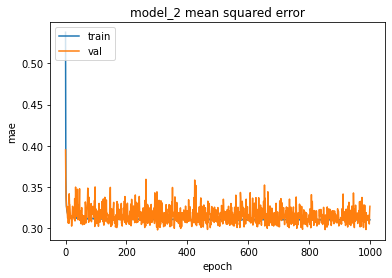

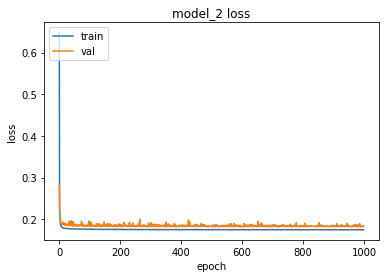

In [90]:
model2 = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", name="input"),
    keras.layers.Dense(1)
])

model2.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae'])
model2_fit = model2.fit(X_train, y_train, epochs=1000,
                   validation_data=(X_test, y_test))

plt.plot(model2_fit.history['mae'])
plt.plot(model2_fit.history['val_mae'])
plt.title('model_2 mean squared error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model2_fit.history['loss'])
plt.plot(model2_fit.history['val_loss'])
plt.title('model_2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.6880 - mae: 0.4756 - val_loss: 0.2227 - val_mae: 0.3801
Epoch 2/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1904 - mae: 0.3228 - val_loss: 0.1892 - val_mae: 0.3217
Epoch 3/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1842 - mae: 0.3179 - val_loss: 0.2097 - val_mae: 0.3029
Epoch 4/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1824 - mae: 0.3168 - val_loss: 0.1963 - val_mae: 0.3010
Epoch 5/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1807 - mae: 0.3155 - val_loss: 0.1859 - val_mae: 0.3212
Epoch 6/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1807 - mae: 0.3153 - val_loss: 0.1930 - val_mae: 0.3003
Epoch 7/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1798 - mae: 0.3148 - val_loss: 0.1854 - val_mae: 0.3128
Epoch 8/1000
586/586 [==============================] - 1s 2ms

Epoch 62/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1758 - mae: 0.3110 - val_loss: 0.2077 - val_mae: 0.3763
Epoch 63/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1753 - mae: 0.3110 - val_loss: 0.1820 - val_mae: 0.3141
Epoch 64/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1755 - mae: 0.3109 - val_loss: 0.1824 - val_mae: 0.3161
Epoch 65/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1755 - mae: 0.3110 - val_loss: 0.1940 - val_mae: 0.3529
Epoch 66/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1754 - mae: 0.3109 - val_loss: 0.1957 - val_mae: 0.3553
Epoch 67/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1750 - mae: 0.3107 - val_loss: 0.1913 - val_mae: 0.2984
Epoch 68/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1754 - mae: 0.3105 - val_loss: 0.1819 - val_mae: 0.3194
Epoch 69/1000
586/586 [==============================] 

586/586 [==============================] - 1s 2ms/step - loss: 0.1741 - mae: 0.3095 - val_loss: 0.1817 - val_mae: 0.3149
Epoch 123/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1742 - mae: 0.3093 - val_loss: 0.1892 - val_mae: 0.3413
Epoch 124/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1742 - mae: 0.3097 - val_loss: 0.1828 - val_mae: 0.3103
Epoch 125/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1743 - mae: 0.3096 - val_loss: 0.1817 - val_mae: 0.3128
Epoch 126/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1740 - mae: 0.3093 - val_loss: 0.1900 - val_mae: 0.2992
Epoch 127/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1740 - mae: 0.3092 - val_loss: 0.1824 - val_mae: 0.3072
Epoch 128/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1740 - mae: 0.3092 - val_loss: 0.1831 - val_mae: 0.3201
Epoch 129/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1733 - mae: 0.3082 - val_loss: 0.1817 - val_mae: 0.3138
Epoch 183/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1731 - mae: 0.3082 - val_loss: 0.2145 - val_mae: 0.3839
Epoch 184/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1731 - mae: 0.3084 - val_loss: 0.1820 - val_mae: 0.3169
Epoch 185/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1728 - mae: 0.3077 - val_loss: 0.1835 - val_mae: 0.3221
Epoch 186/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1729 - mae: 0.3081 - val_loss: 0.1830 - val_mae: 0.3069
Epoch 187/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1731 - mae: 0.3086 - val_loss: 0.1938 - val_mae: 0.2978
Epoch 188/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1732 - mae: 0.3082 - val_loss: 0.1853 - val_mae: 0.3295
Epoch 189/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1727 - mae: 0.3079 - val_loss: 0.1905 - val_mae: 0.3444
Epoch 243/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1723 - mae: 0.3075 - val_loss: 0.1837 - val_mae: 0.3056
Epoch 244/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1727 - mae: 0.3076 - val_loss: 0.1837 - val_mae: 0.3050
Epoch 245/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1725 - mae: 0.3075 - val_loss: 0.1975 - val_mae: 0.3580
Epoch 246/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1722 - mae: 0.3077 - val_loss: 0.1970 - val_mae: 0.2975
Epoch 247/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1722 - mae: 0.3068 - val_loss: 0.1833 - val_mae: 0.3205
Epoch 248/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1725 - mae: 0.3079 - val_loss: 0.1833 - val_mae: 0.3074
Epoch 249/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1722 - mae: 0.3071 - val_loss: 0.1945 - val_mae: 0.3505
Epoch 303/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1718 - mae: 0.3068 - val_loss: 0.1851 - val_mae: 0.3045
Epoch 304/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1716 - mae: 0.3066 - val_loss: 0.1837 - val_mae: 0.3065
Epoch 305/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1720 - mae: 0.3069 - val_loss: 0.1837 - val_mae: 0.3081
Epoch 306/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1718 - mae: 0.3068 - val_loss: 0.1928 - val_mae: 0.3492
Epoch 307/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1715 - mae: 0.3067 - val_loss: 0.1927 - val_mae: 0.3475
Epoch 308/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1717 - mae: 0.3067 - val_loss: 0.1960 - val_mae: 0.3557
Epoch 309/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1714 - mae: 0.3064 - val_loss: 0.1829 - val_mae: 0.3121
Epoch 363/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1710 - mae: 0.3061 - val_loss: 0.1838 - val_mae: 0.3108
Epoch 364/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1714 - mae: 0.3065 - val_loss: 0.1901 - val_mae: 0.3426
Epoch 365/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1714 - mae: 0.3066 - val_loss: 0.1853 - val_mae: 0.3044
Epoch 366/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1714 - mae: 0.3062 - val_loss: 0.1920 - val_mae: 0.3477
Epoch 367/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1717 - mae: 0.3068 - val_loss: 0.1861 - val_mae: 0.3038
Epoch 368/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1715 - mae: 0.3065 - val_loss: 0.1832 - val_mae: 0.3192
Epoch 369/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1711 - mae: 0.3060 - val_loss: 0.1910 - val_mae: 0.3005
Epoch 423/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1707 - mae: 0.3059 - val_loss: 0.1941 - val_mae: 0.2987
Epoch 424/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1708 - mae: 0.3055 - val_loss: 0.1838 - val_mae: 0.3209
Epoch 425/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1708 - mae: 0.3061 - val_loss: 0.1889 - val_mae: 0.3007
Epoch 426/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1710 - mae: 0.3058 - val_loss: 0.1846 - val_mae: 0.3259
Epoch 427/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1707 - mae: 0.3061 - val_loss: 0.1838 - val_mae: 0.3221
Epoch 428/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1710 - mae: 0.3063 - val_loss: 0.1943 - val_mae: 0.3027
Epoch 429/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1703 - mae: 0.3054 - val_loss: 0.1862 - val_mae: 0.3026
Epoch 483/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1707 - mae: 0.3057 - val_loss: 0.1911 - val_mae: 0.2989
Epoch 484/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1706 - mae: 0.3053 - val_loss: 0.1831 - val_mae: 0.3100
Epoch 485/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1705 - mae: 0.3056 - val_loss: 0.1935 - val_mae: 0.3486
Epoch 486/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1702 - mae: 0.3058 - val_loss: 0.1877 - val_mae: 0.3017
Epoch 487/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1704 - mae: 0.3053 - val_loss: 0.1856 - val_mae: 0.3061
Epoch 488/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1708 - mae: 0.3057 - val_loss: 0.1835 - val_mae: 0.3178
Epoch 489/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1703 - mae: 0.3053 - val_loss: 0.1847 - val_mae: 0.3068
Epoch 543/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1699 - mae: 0.3050 - val_loss: 0.1833 - val_mae: 0.3128
Epoch 544/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1701 - mae: 0.3049 - val_loss: 0.1896 - val_mae: 0.3017
Epoch 545/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1699 - mae: 0.3051 - val_loss: 0.1829 - val_mae: 0.3131
Epoch 546/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1699 - mae: 0.3049 - val_loss: 0.1891 - val_mae: 0.2998
Epoch 547/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1703 - mae: 0.3052 - val_loss: 0.1833 - val_mae: 0.3107
Epoch 548/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1698 - mae: 0.3046 - val_loss: 0.1853 - val_mae: 0.3286
Epoch 549/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1696 - mae: 0.3046 - val_loss: 0.1892 - val_mae: 0.3006
Epoch 603/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1698 - mae: 0.3050 - val_loss: 0.1907 - val_mae: 0.3002
Epoch 604/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1695 - mae: 0.3045 - val_loss: 0.1868 - val_mae: 0.3043
Epoch 605/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1696 - mae: 0.3045 - val_loss: 0.1839 - val_mae: 0.3192
Epoch 606/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1696 - mae: 0.3049 - val_loss: 0.1836 - val_mae: 0.3111
Epoch 607/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1698 - mae: 0.3048 - val_loss: 0.1899 - val_mae: 0.3412
Epoch 608/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1698 - mae: 0.3048 - val_loss: 0.1846 - val_mae: 0.3070
Epoch 609/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1695 - mae: 0.3046 - val_loss: 0.1844 - val_mae: 0.3087
Epoch 663/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1695 - mae: 0.3043 - val_loss: 0.1892 - val_mae: 0.3043
Epoch 664/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1692 - mae: 0.3041 - val_loss: 0.1886 - val_mae: 0.3035
Epoch 665/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1694 - mae: 0.3046 - val_loss: 0.1852 - val_mae: 0.3090
Epoch 666/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1693 - mae: 0.3046 - val_loss: 0.1856 - val_mae: 0.3062
Epoch 667/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1694 - mae: 0.3042 - val_loss: 0.2146 - val_mae: 0.3840
Epoch 668/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1694 - mae: 0.3046 - val_loss: 0.1844 - val_mae: 0.3215
Epoch 669/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1690 - mae: 0.3043 - val_loss: 0.2017 - val_mae: 0.3005
Epoch 723/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1692 - mae: 0.3047 - val_loss: 0.1858 - val_mae: 0.3197
Epoch 724/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1691 - mae: 0.3039 - val_loss: 0.1848 - val_mae: 0.3109
Epoch 725/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1690 - mae: 0.3040 - val_loss: 0.1969 - val_mae: 0.3527
Epoch 726/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1691 - mae: 0.3040 - val_loss: 0.1861 - val_mae: 0.3061
Epoch 727/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1688 - mae: 0.3039 - val_loss: 0.1878 - val_mae: 0.3331
Epoch 728/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1690 - mae: 0.3043 - val_loss: 0.1837 - val_mae: 0.3162
Epoch 729/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1687 - mae: 0.3039 - val_loss: 0.1862 - val_mae: 0.3228
Epoch 783/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1686 - mae: 0.3036 - val_loss: 0.1892 - val_mae: 0.3031
Epoch 784/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1688 - mae: 0.3041 - val_loss: 0.1953 - val_mae: 0.3007
Epoch 785/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1689 - mae: 0.3036 - val_loss: 0.2068 - val_mae: 0.3708
Epoch 786/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1684 - mae: 0.3039 - val_loss: 0.1844 - val_mae: 0.3122
Epoch 787/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1689 - mae: 0.3042 - val_loss: 0.1848 - val_mae: 0.3092
Epoch 788/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1683 - mae: 0.3037 - val_loss: 0.1860 - val_mae: 0.3075
Epoch 789/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1685 - mae: 0.3040 - val_loss: 0.1885 - val_mae: 0.3341
Epoch 843/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1685 - mae: 0.3037 - val_loss: 0.1897 - val_mae: 0.3050
Epoch 844/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1685 - mae: 0.3036 - val_loss: 0.1845 - val_mae: 0.3145
Epoch 845/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1681 - mae: 0.3036 - val_loss: 0.1944 - val_mae: 0.3489
Epoch 846/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1685 - mae: 0.3040 - val_loss: 0.1846 - val_mae: 0.3149
Epoch 847/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1684 - mae: 0.3036 - val_loss: 0.1895 - val_mae: 0.3379
Epoch 848/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1688 - mae: 0.3041 - val_loss: 0.1858 - val_mae: 0.3110
Epoch 849/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1680 - mae: 0.3033 - val_loss: 0.2395 - val_mae: 0.4130
Epoch 903/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1679 - mae: 0.3036 - val_loss: 0.1873 - val_mae: 0.3306
Epoch 904/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1683 - mae: 0.3035 - val_loss: 0.2006 - val_mae: 0.3020
Epoch 905/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1682 - mae: 0.3035 - val_loss: 0.1932 - val_mae: 0.3442
Epoch 906/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1682 - mae: 0.3037 - val_loss: 0.1858 - val_mae: 0.3201
Epoch 907/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1678 - mae: 0.3032 - val_loss: 0.1849 - val_mae: 0.3127
Epoch 908/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1679 - mae: 0.3035 - val_loss: 0.1947 - val_mae: 0.3494
Epoch 909/1000
586/586 [==============================] - 1s 2m

586/586 [==============================] - 1s 2ms/step - loss: 0.1677 - mae: 0.3030 - val_loss: 0.2036 - val_mae: 0.3027
Epoch 963/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1675 - mae: 0.3026 - val_loss: 0.1871 - val_mae: 0.3306
Epoch 964/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1676 - mae: 0.3031 - val_loss: 0.2112 - val_mae: 0.3770
Epoch 965/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1679 - mae: 0.3036 - val_loss: 0.1926 - val_mae: 0.3027
Epoch 966/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1679 - mae: 0.3037 - val_loss: 0.1848 - val_mae: 0.3134
Epoch 967/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1680 - mae: 0.3034 - val_loss: 0.1980 - val_mae: 0.3558
Epoch 968/1000
586/586 [==============================] - 1s 2ms/step - loss: 0.1676 - mae: 0.3031 - val_loss: 0.1862 - val_mae: 0.3136
Epoch 969/1000
586/586 [==============================] - 1s 2m

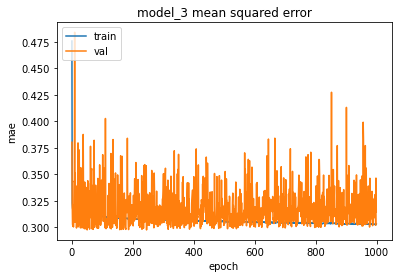

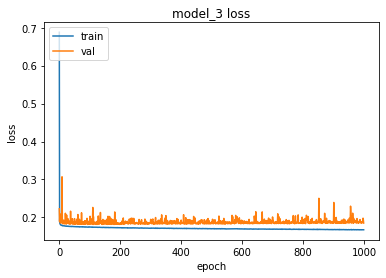

In [91]:
model3 = keras.models.Sequential([
    keras.layers.Dense(10, activation="relu", name="input"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dense(1)
])

model3.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae'])
model3_fit = model3.fit(X_train, y_train, epochs=1000,
                   validation_data=(X_test, y_test))

plt.plot(model3_fit.history['mae'])
plt.plot(model3_fit.history['val_mae'])
plt.title('model_3 mean squared error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model3_fit.history['loss'])
plt.plot(model3_fit.history['val_loss'])
plt.title('model_3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()